# Process and Export Correlation Table and Correlation Plots

This is the main runner script for generating the `correlations.csv` file.

The script collects all of the data needed to make correlation plots. This includes data during formation and aging cycles. Aging cycles include the diagnostic tests as well as the 1C/1C charge/discharge. Summarize the results and plot correlations.

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../')
sys.path.append('code')

import numpy as np
import pandas as pd
import glob
import pprint
from scipy.stats import pearsonr
from datetime import datetime
from scipy.stats import ttest_ind
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import re
from src.formation import FormationCell

In [2]:
assert os.path.basename(os.getcwd()) == 'project-formation'

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Configure paths

In [4]:
OUTPUT_PATH = 'output/2021-03-fast-formation-esoh-fits/'

## Configure plot settings

In [5]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Times New Roman'],
                  'size': 26
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (10, 8),
                    'facecolor'  : 'white'
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=True)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')



DPI = 600
VOLTAGE_LIMITS = (2.95, 4.25)
CAPACITY_LIMITS = (0, 3)

ORANGE = (1, 0.5, 0)
BLUE = (0, 0.5, 1)
BLACK = (0.0, 0.0, 0.0)
GREEN = (0, 0.75, 0)
ORANGE = (1, 0.5, 0)

## Load resources

In [6]:
formation_cells = []
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    formation_cells.append(FormationCell(cellid))
    
for cell in formation_cells:
    print(cell)

Formation Cell 1
Formation Cell 2
Formation Cell 3
Formation Cell 4
Formation Cell 5
Formation Cell 6
Formation Cell 7
Formation Cell 8
Formation Cell 9
Formation Cell 10
Formation Cell 11
Formation Cell 12
Formation Cell 13
Formation Cell 14
Formation Cell 15
Formation Cell 16
Formation Cell 17
Formation Cell 18
Formation Cell 19
Formation Cell 20
Formation Cell 21
Formation Cell 22
Formation Cell 23
Formation Cell 24
Formation Cell 25
Formation Cell 26
Formation Cell 27
Formation Cell 28
Formation Cell 29
Formation Cell 30
Formation Cell 31
Formation Cell 32
Formation Cell 33
Formation Cell 34
Formation Cell 35
Formation Cell 36
Formation Cell 37
Formation Cell 38
Formation Cell 39
Formation Cell 40


## Compile and export the table containing all of the results

This compilation will include data from:
- formation
- cycling
- eSOH metrics

In [7]:
all_summary_data = []

for cell in formation_cells:
    
    if cell.cellid == 9:
        continue
        
    print(f'Working on compiling data on cell #{cell.cellid}...')
    
    curr_summary = dict()

    curr_summary['cellid'] = cell.cellid
    curr_summary['channel_number'] = cell.get_channel_number()
    curr_summary['is_room_temp_aging'] = 1 if cell.is_room_temp() else 0
    curr_summary['is_baseline_formation'] = 1 if cell.is_baseline_formation() else 0
    
    # Add information from the formation cycles
    curr_summary.update(cell.get_formation_test_summary_statistics())
    curr_summary['form_coulombic_efficiency'] = curr_summary['form_final_discharge_capacity_ah'] / curr_summary['form_first_charge_capacity_ah']
    
    # Add the results from the aging test
    curr_summary.update(cell.get_aging_test_summary_statistics())
    
    # Add the 1-hour delta V measurements from the RPTs
    voltage_res_array = cell.process_diagnostic_4p2v_voltage_decay()
    for voltage_res in voltage_res_array:
        curr_summary[f'rpt_c{voltage_res["cycle_index"]}_delta_v'] = voltage_res['delta_voltage']
    
    # Add the eSOH fitting results for two different cycle numbers
    df_esoh = cell.get_esoh_fitting_results()
    esoh_common_cycles_arr = [3, 56, 159, 262, 365]
    for cyc_idx in esoh_common_cycles_arr:
        df_curr = df_esoh[df_esoh['cycle_number'] == cyc_idx].drop(columns=['cellid', 'cycle_number'])
        curr_summary.update(df_curr.add_prefix(f'esoh_c{cyc_idx}_').to_dict('records')[0])
        curr_summary[f'esoh_c{cyc_idx}_CnCp'] = curr_summary[f'esoh_c{cyc_idx}_Cn'] / curr_summary[f'esoh_c{cyc_idx}_Cp']
                           
    curr_summary['is_plating'] = 1 if cell.is_plating() else 0
    curr_summary['swelling_severity'] = cell.get_swelling_severity()
    curr_summary['thickness_mm'] = cell.get_thickness()
    curr_summary['electrolyte_weight_g'] = cell.get_electrolyte_weight()
    
    all_summary_data.append(curr_summary)
    
df_corr = pd.DataFrame(all_summary_data)

Working on compiling data on cell #1...
Working on compiling data on cell #2...
Working on compiling data on cell #3...
Working on compiling data on cell #4...
Working on compiling data on cell #5...
Working on compiling data on cell #6...
Working on compiling data on cell #7...
Working on compiling data on cell #8...
Working on compiling data on cell #10...
Working on compiling data on cell #11...
Working on compiling data on cell #12...
Working on compiling data on cell #13...
Working on compiling data on cell #14...
Working on compiling data on cell #15...
Working on compiling data on cell #16...
Working on compiling data on cell #17...
Working on compiling data on cell #18...
Working on compiling data on cell #19...
Working on compiling data on cell #20...
Working on compiling data on cell #21...
Working on compiling data on cell #22...
Working on compiling data on cell #23...
Working on compiling data on cell #24...
Working on compiling data on cell #25...
Working on compiling dat

In [8]:
df_corr.columns

Index(['cellid', 'channel_number', 'is_room_temp_aging',
       'is_baseline_formation', 'form_first_discharge_capacity_below_3p2v_ah',
       'form_first_discharge_rest_voltage_rebound_1s',
       'form_first_discharge_rest_voltage_rebound_10s',
       'form_first_discharge_rest_voltage_rebound_1800s',
       'form_last_charge_voltage_trace_cap_ah',
       'form_last_charge_voltage_trace_voltage_v',
       ...
       'var_q_c471_c3', 'rpt_c471_delta_v', 'var_q_c524_c3', 'var_q_c577_c3',
       'rpt_c524_delta_v', 'rpt_c577_delta_v', 'var_q_c630_c3',
       'rpt_c630_delta_v', 'var_q_c574_c3', 'rpt_c574_delta_v'],
      dtype='object', length=636)

In [9]:
df_corr

cellid  channel_number  is_room_temp_aging  is_baseline_formation  \
0        1              22                   0                      1   
1        2              23                   0                      1   
2        3              24                   0                      1   
3        4              25                   0                      1   
4        5              26                   0                      1   
5        6              27                   0                      1   
6        7              28                   0                      1   
7        8              29                   0                      1   
8       10              31                   0                      1   
9       11               1                   1                      1   
10      12               2                   1                      1   
11      13               3                   1                      1   
12      14               4                   1                      1   
13      15               5                   1                      1   
14      16               6                   1                      1   
15      17               7                   1                      1   
16      18               8                   1                      1   
17      19              10                   1                      1   
18      20              11                   1                      1   
19      21              12                   1                      0   
20      22              13                   1                      0   
21      23              14                   1                      0   
22      24              15                   1                      0   
23      25              16                   1                      0   
24      26              17                   1                      0   
25      27              18                   1                      0   
26      28              19                   1                      0   
27      29              20                   1                      0   
28      30              21                   1                      0   
29      31              32                   0                      0   
30      32              33                   0                      0   
31      33              34                   0                      0   
32      34              35                   0                      0   
33      35              36                   0                      0   
34      36              37                   0                      0   
35      37              38                   0                      0   
36      38              39                   0                      0   
37      39              40                   0                      0   
38      40              41                   0                      0   

    form_first_discharge_capacity_below_3p2v_ah  \
0                                      0.077820   
1                                      0.073791   
2                                      0.074725   
3                                      0.069433   
4                                      0.073127   
5                                      0.071483   
6                                      0.076523   
7                                      0.066771   
8                                      0.070995   
9                                      0.076570   
10                                     0.076687   
11                                     0.072891   
12                                     0.078141   
13                                     0.080460   
14                                     0.074184   
15                                     0.069909   
16                                     0.070156   
17                                     0.075486   
18                                     0.072030   
19                                     0.028163   
20          

In [10]:
df_corr.to_csv(f'{OUTPUT_PATH}/correlation_data.csv')

In [11]:
df_corr_rt = df_corr[df_corr['is_room_temp_aging'] == True]
# df_corr_rt = df_corr_rt.drop(columns=['cellid', 'is_baseline_formation', 'is_room_temp_aging'])
df_corr_ht = df_corr[df_corr['is_room_temp_aging'] == False]
# df_corr_ht = df_corr_ht.drop(columns=['cellid', 'is_baseline_formation', 'is_room_temp_aging'])

# df_corr = df_corr.drop(columns=['cellid', 'is_baseline_formation', 'is_room_temp_aging'])


## Make some correlation plots

## The correlation plot for hot temperatures

In [12]:
df_corr_ht

cellid  channel_number  is_room_temp_aging  is_baseline_formation  \
0        1              22                   0                      1   
1        2              23                   0                      1   
2        3              24                   0                      1   
3        4              25                   0                      1   
4        5              26                   0                      1   
5        6              27                   0                      1   
6        7              28                   0                      1   
7        8              29                   0                      1   
8       10              31                   0                      1   
29      31              32                   0                      0   
30      32              33                   0                      0   
31      33              34                   0                      0   
32      34              35                   0                      0   
33      35              36                   0                      0   
34      36              37                   0                      0   
35      37              38                   0                      0   
36      38              39                   0                      0   
37      39              40                   0                      0   
38      40              41                   0                      0   

    form_first_discharge_capacity_below_3p2v_ah  \
0                                      0.077820   
1                                      0.073791   
2                                      0.074725   
3                                      0.069433   
4                                      0.073127   
5                                      0.071483   
6                                      0.076523   
7                                      0.066771   
8                                      0.070995   
29                                     0.025480   
30                                     0.023201   
31                                     0.023901   
32                                     0.023699   
33                                     0.024648   
34                                     0.024111   
35                                     0.026001   
36                                     0.023123   
37                                     0.023870   
38                                     0.024865   

    form_first_discharge_rest_voltage_rebound_1s  \
0                                       3.010586   
1                                       3.011151   
2                                       3.010842   
3                                       3.010670   
4                                       3.010769   
5                                       3.010406   
6                                       3.010416   
7                                       3.011265   
8                                       3.010797   
29                                           NaN   
30                                           NaN   
31                                           NaN   
32                                           NaN   
33                                           NaN   
34                                           NaN   
35                                           NaN   
36                                           NaN   
37                                           NaN   
38                                           NaN   

    form_first_discharge_rest_voltage_rebound_10s  \
0                                        3.057576   
1                                        3.061895   
2                                        3.060853   
3                                        3.059812   
4                                        3.060117   
5                                        3.054375   
6                                        3.057246   
7                                        3.062353   
8   

## High Temperature Correlation Plot

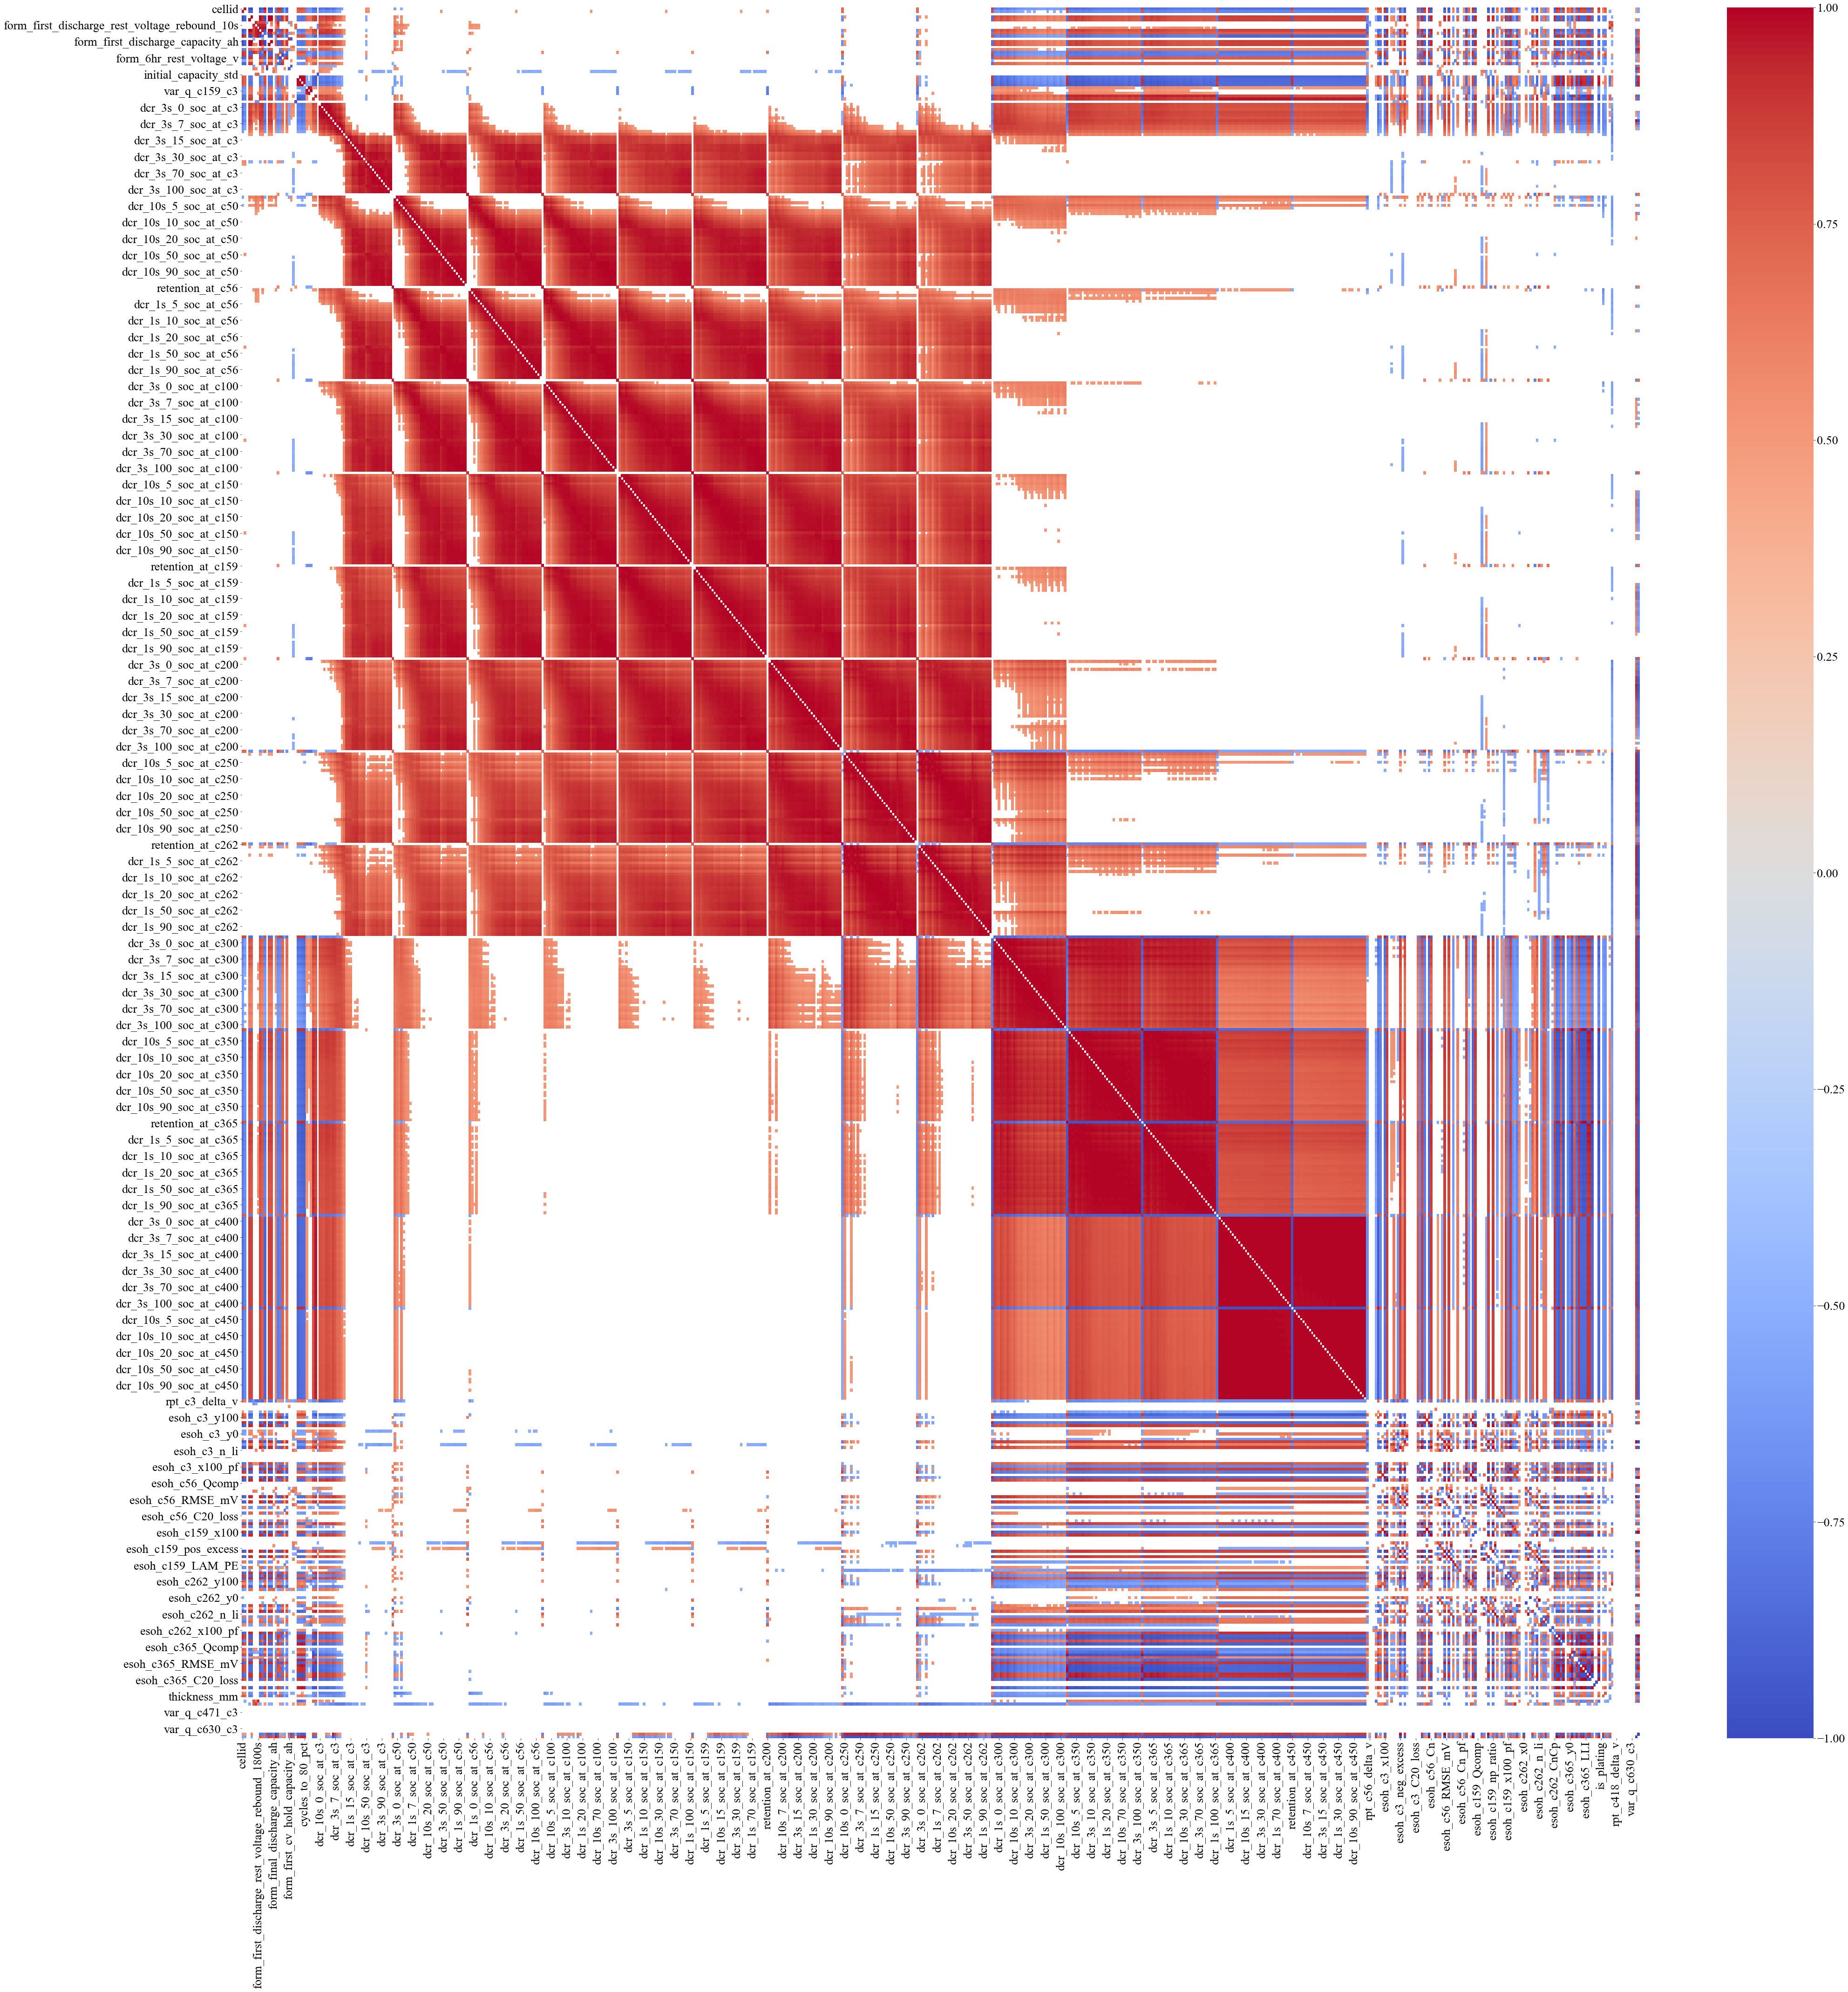

In [13]:
dfCorr = df_corr_ht.corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
fig = plt.figure(figsize=(60,60))
sns.heatmap(filteredDf, annot=False, cmap="coolwarm")
plt.savefig('correlation_matrix_ht.png')
plt.show()

## Room Temperature Correlation Plot

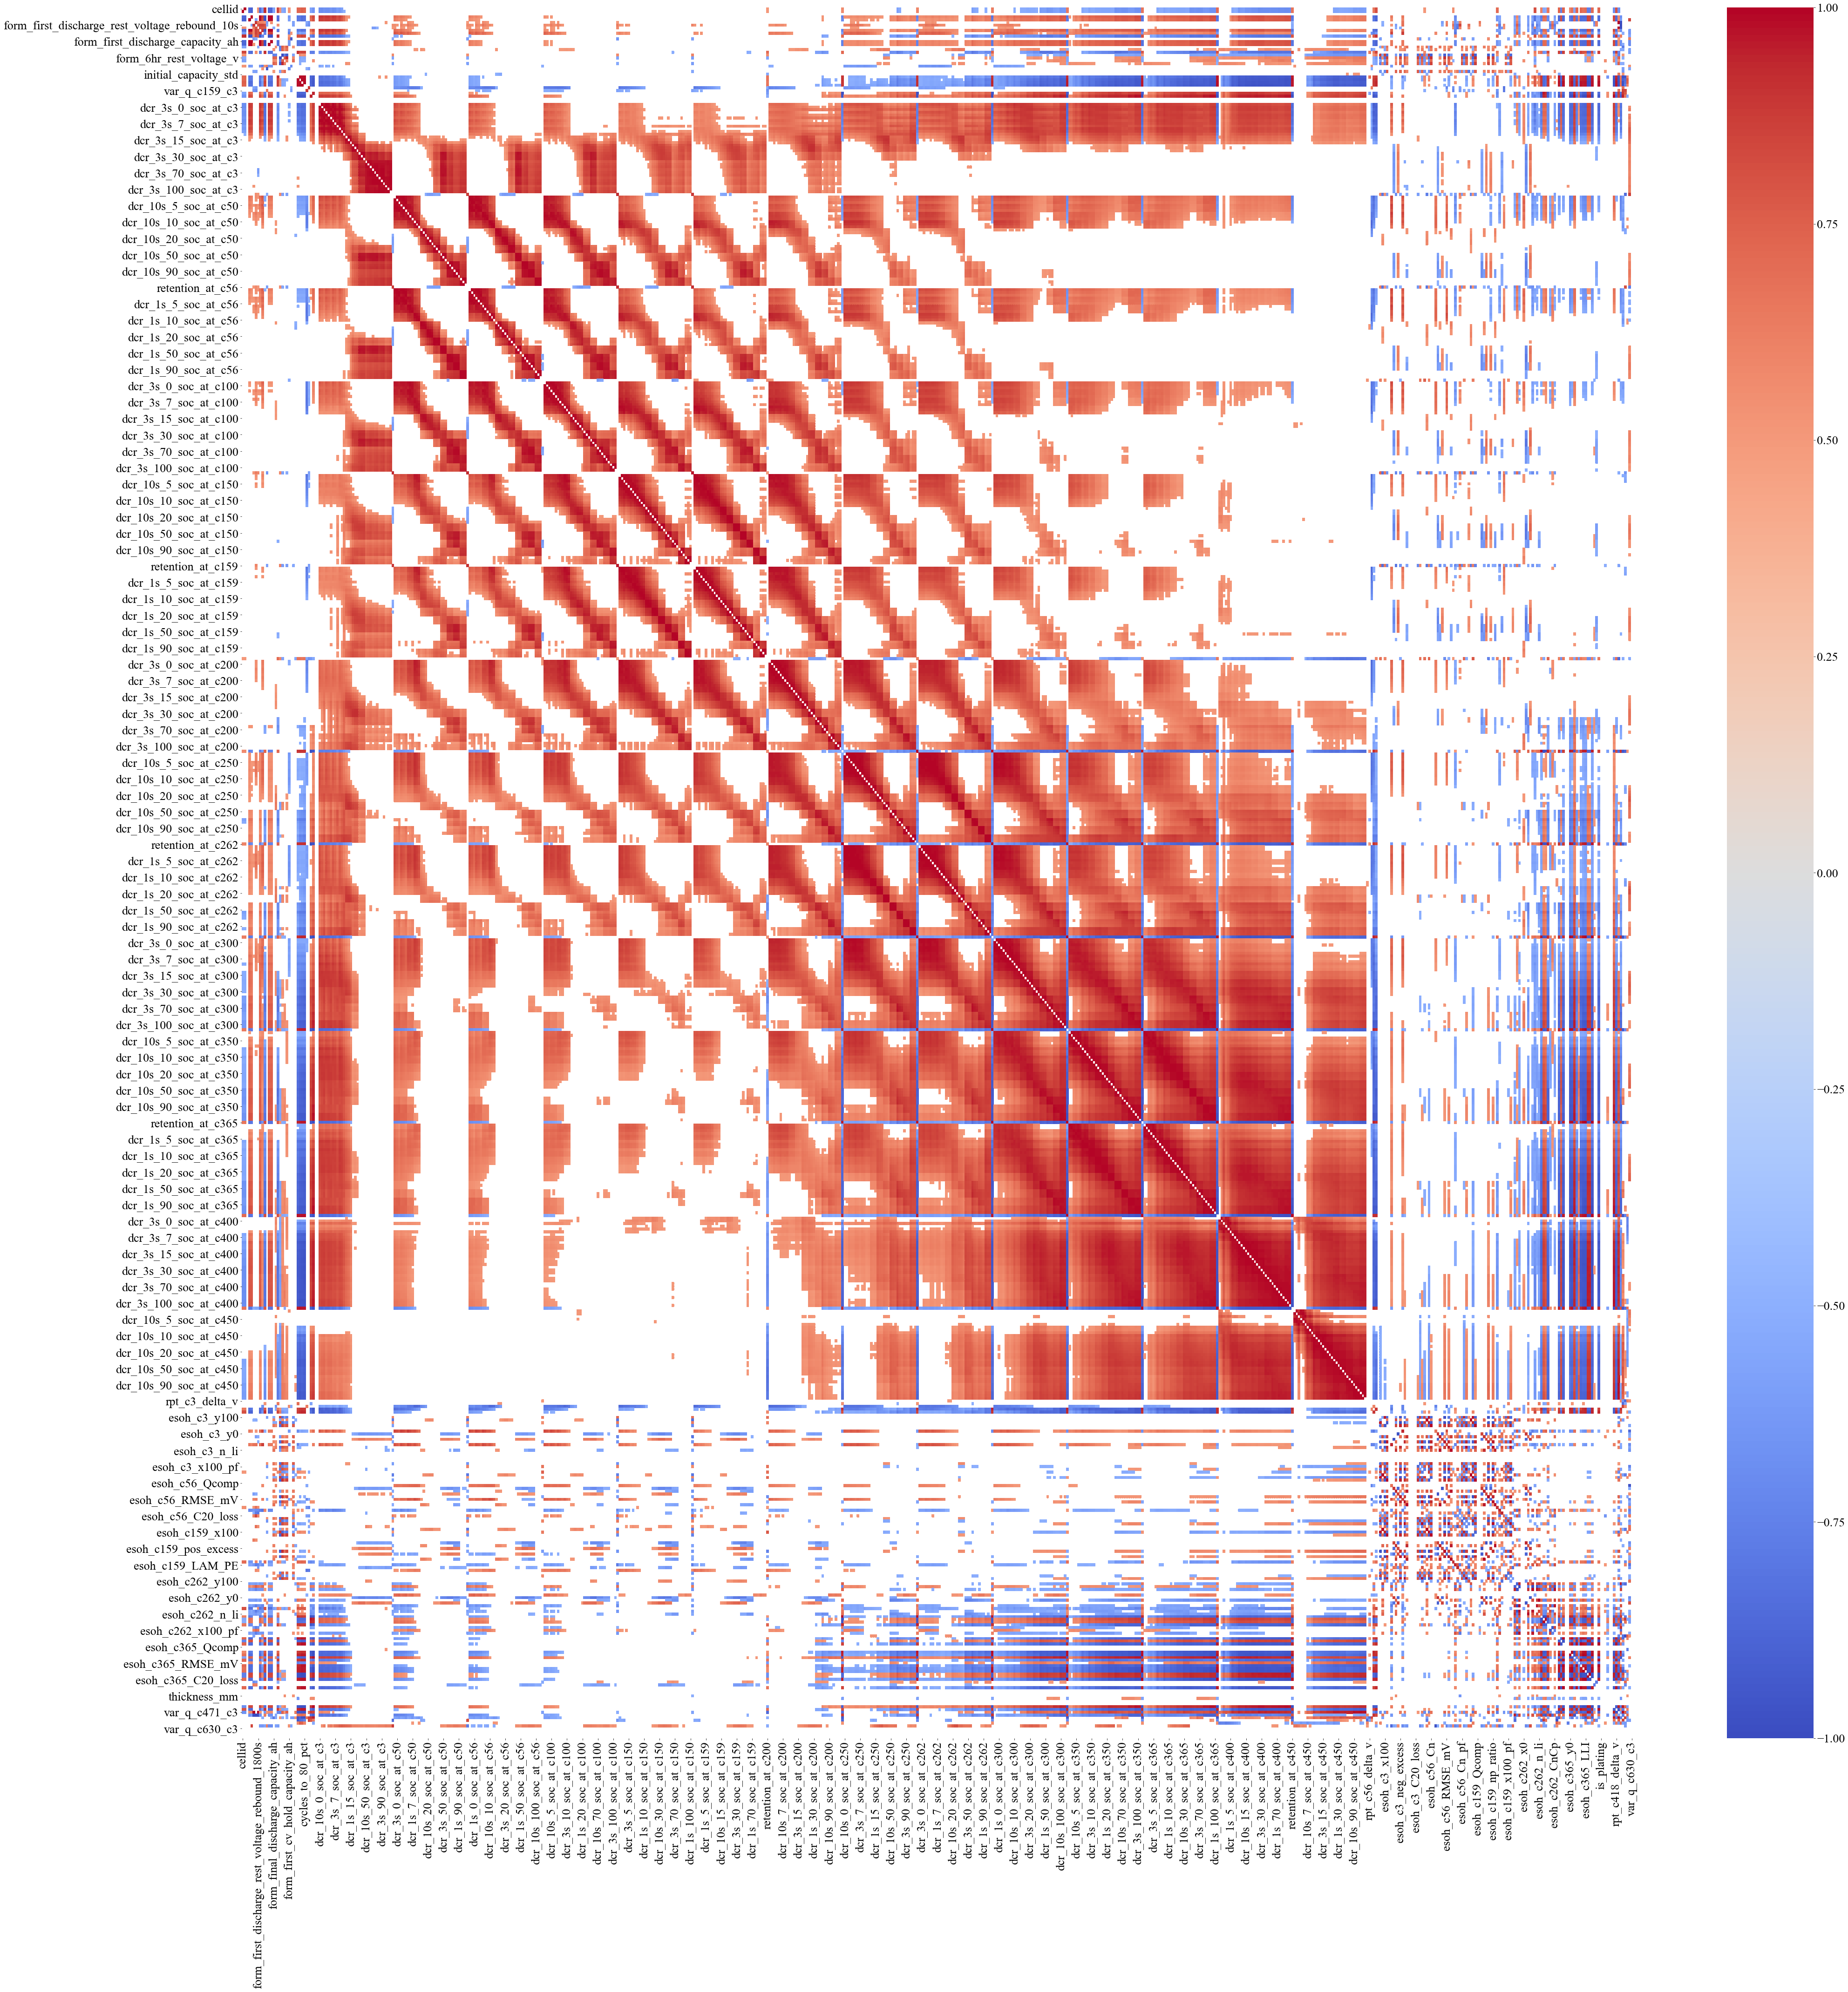

In [14]:
dfCorr = df_corr_rt.corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
fig = plt.figure(figsize=(60,60))
sns.heatmap(filteredDf, annot=False, cmap="coolwarm")
plt.savefig('correlation_matrix_rt.png')
plt.show()

## Correlation Plot - High Temp and Room Temp

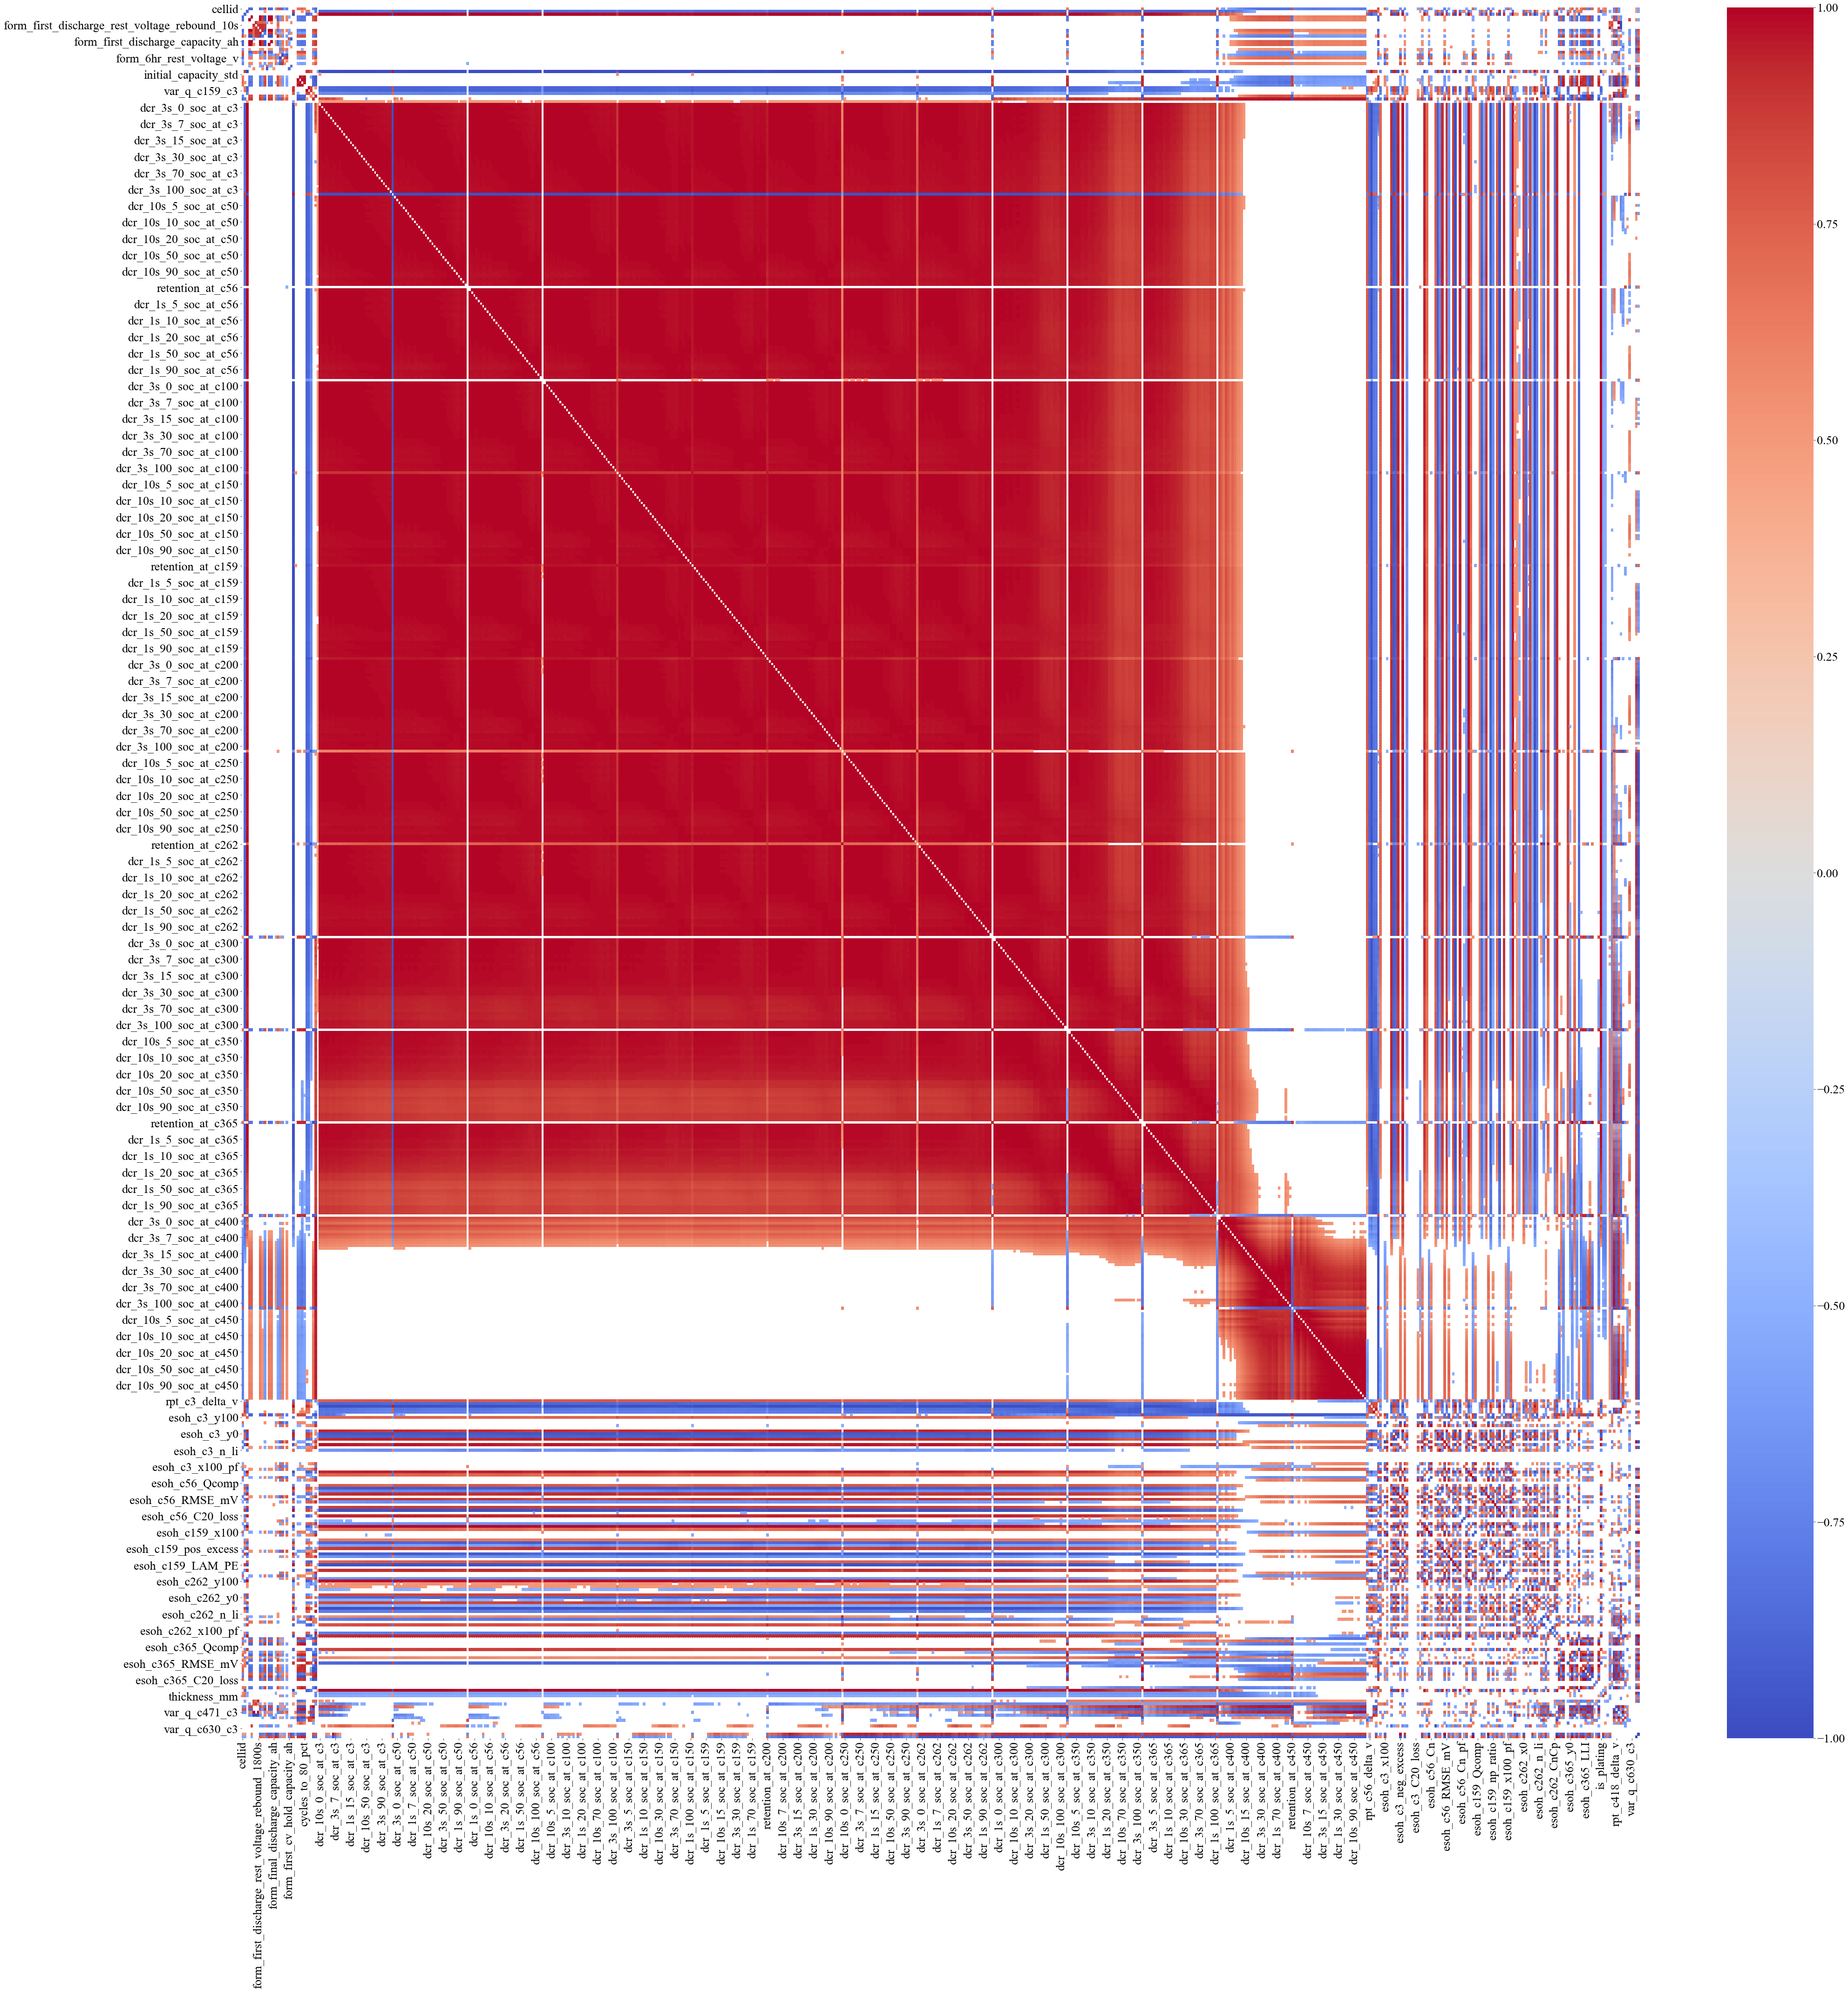

In [15]:
dfCorr = df_corr.corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
fig = plt.figure(figsize=(60,60))
sns.heatmap(filteredDf, annot=False, cmap="coolwarm")
plt.savefig('correlation_matrix_all.png')
plt.show()

In [16]:
print(f'There will be { len(df_corr.columns)} x {(len(df_corr.columns) - 1)} correlations.')

There will be 636 x 635 correlations.


Processing cellid...


ValueError: ('Lengths must match to compare', (21,), (39,))

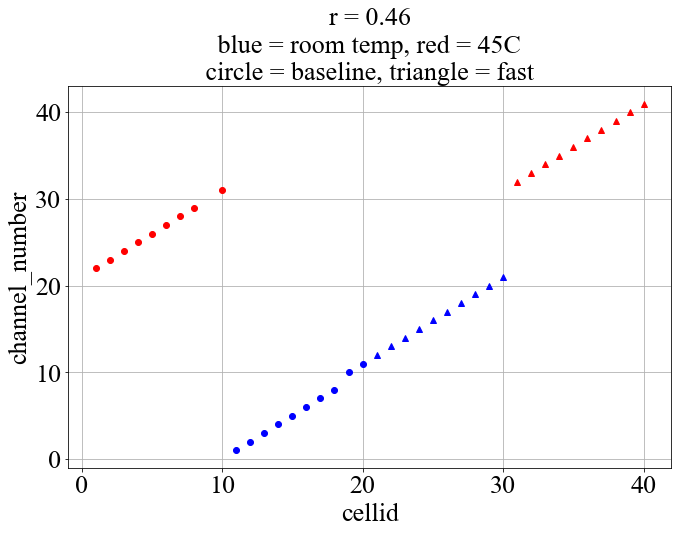

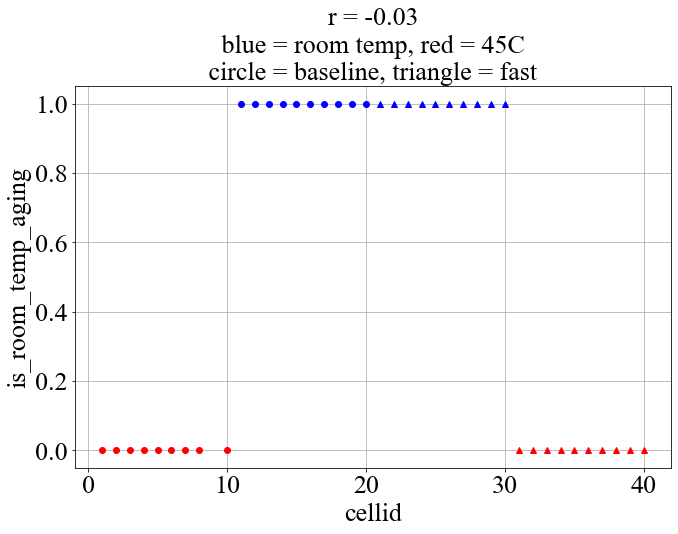

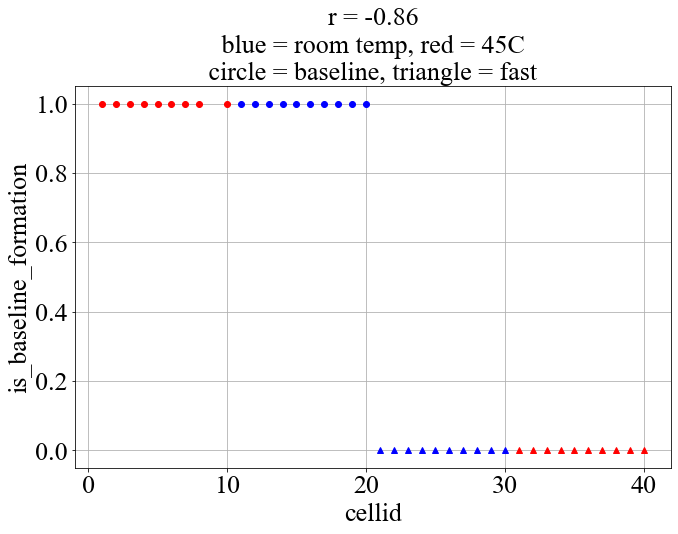

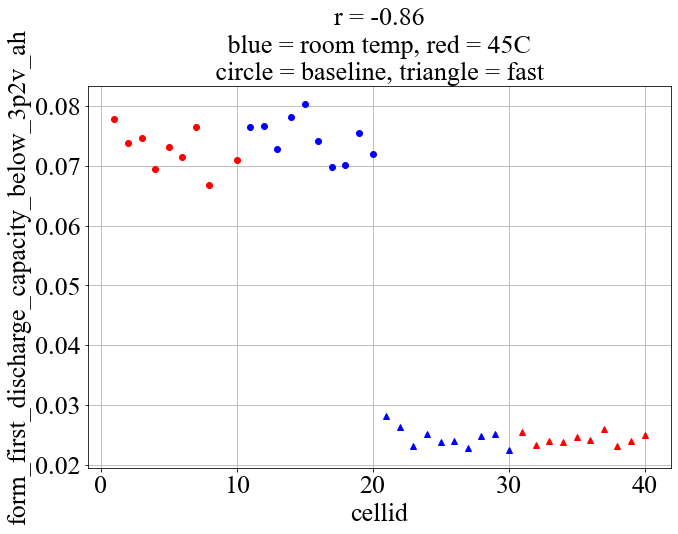

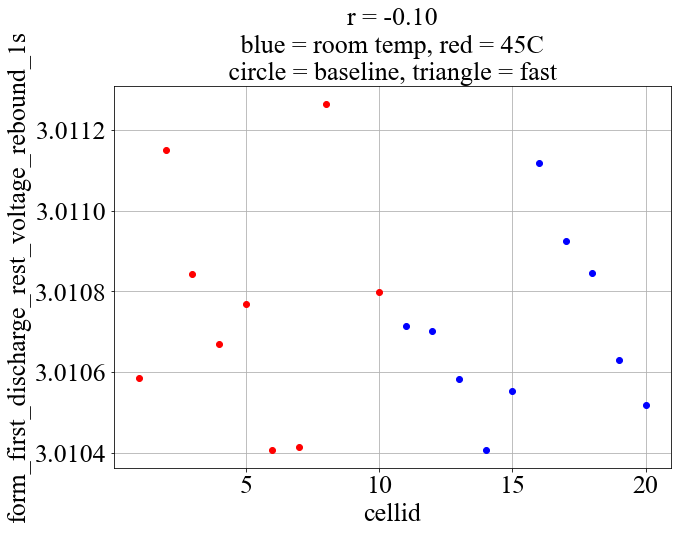

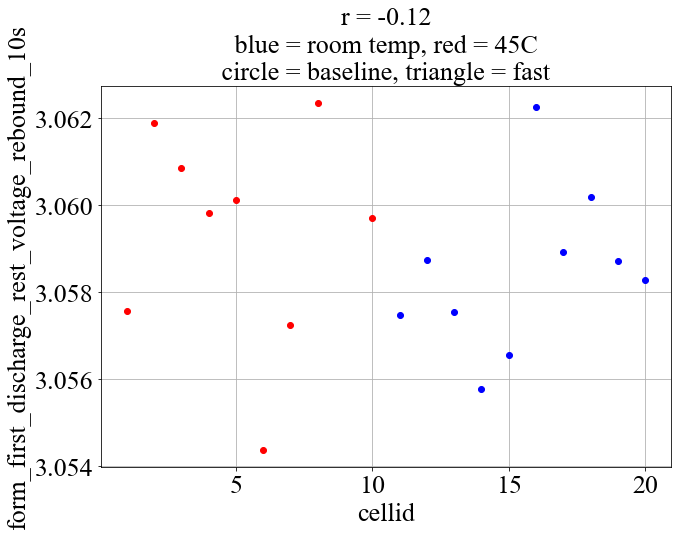

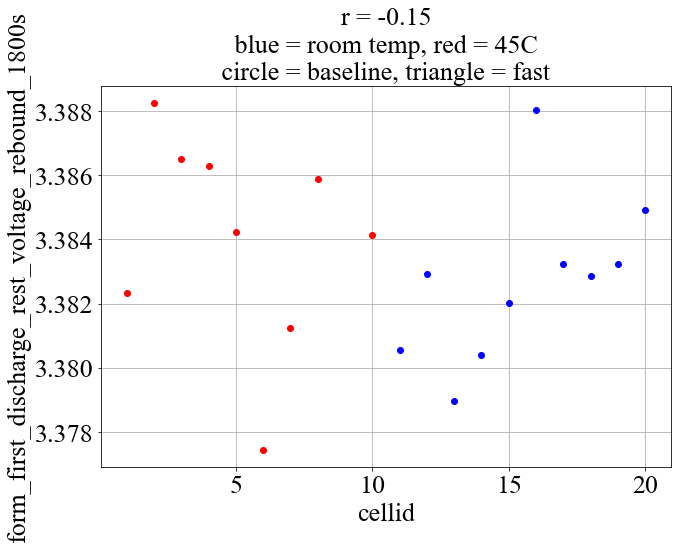

In [17]:
OUTPUT_CORR_PATH = 'output/2021-02-correlations'

for i in range(0, len(df_corr.columns)):
    
    print(f'Processing {df_corr.columns[i]}...')
    
    for j in range(0, len(df_corr.columns)):
        
        if i == j: 
            continue
            
        var1 = df_corr.columns[i]
        var2 = df_corr.columns[j]

        idx_nan = np.logical_or(df_corr[var1].isna(), df_corr[var2].isna())
        corr, _ = pearsonr(df_corr[var1][~idx_nan], df_corr[var2][~idx_nan])
        

        fig = plt.figure()

        for m in range(0, len(df_corr[var1])):

            color = 'b' if df_corr['is_room_temp_aging'][m] else 'r'
            marker = 'o' if df_corr['is_baseline_formation'][m] else '^'

            plt.plot(df_corr[var1][m], df_corr[var2][m],
                     color=color, marker=marker)

        plt.xlabel(var1)
        plt.ylabel(var2)
        plt.title(f'r = {corr:.2f}\n blue = room temp, red = 45C \n circle = baseline, triangle = fast ')    
        plt.savefig(f'{OUTPUT_CORR_PATH}/individual/corr_{var1}_vs_{var2}_R2_{corr**2:.2f}.png')
      
print('Done.')

### 